In [1]:
from google.cloud import storage
import os
import json
from functools import reduce
import pyspark
import re
from datetime import datetime
from datetime import timezone

In [2]:
sc

<SparkContext master=yarn appName=PySparkShell>

# Table of contents
1. [Utility functions](#Utility-functions)
2. [Data load and preprocessing](#Data-load-and-preprocessing)
3. [Greatest hits queries](#Greatest-hits-queries)
4. [Find users listening sessions](#Find-users-listening-sessions)
5. [Stats about listening sessions](#Stats-about-listening-sessions)
6. [Playlist analysis](#Playlist-analysis)
7. [Incident matrix](#Incident-matrix)
7. [Plots](#Plots)

# Utility functions
Functions below download bucket data from google cloud storage

In [3]:
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    # bucket_name = "your-bucket-name"

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)

    for blob in blobs:
        print(blob.name)

def download_blob(source_blob_name, destination_file_name, bucket_name="songs-lastfm"):
    """Downloads a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    # Construct a client side representation of a blob.
    # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
    # any content from Google Cloud Storage. As we don't need additional data,
    # using `Bucket.blob` is preferred here.
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

def list_blobs(bucket_name="songs-lastfm"):
    """Lists all the blobs in the bucket."""
    # bucket_name = "your-bucket-name"

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)

    return [b.name for b in blobs]

### Create directories and download new files

In [4]:
storage_files = list_blobs()
storage_files = [s for s in storage_files if "sync" not in s]
dirs = set(["/".join(file_name.split("/")[:-1]) for file_name in storage_files])
for d in dirs:
    try:
        os.makedirs(d)
    except:
        pass

import glob
dir_cont = set(glob.glob("data/*/*"))

for f in set(storage_files) - dir_cont:
    print('Downloading: ', f)
    download_blob(f, f)

# Load songs from downloaded files
This creates an RDD containing songs info

The process first builds small rdds with the songs gathered on a particular day, they then are merged to return the full RDD

This prevents from loading too much data outside of an RDD

In [5]:
def get_songs_rdd(dir_name="data/songs"):
    def add_timestamp(d, f):
        s = re.sub(r'[^0-9]', '', f)
        dt = datetime(int(s[0:4]), int(s[4:6]), int(s[6:8]))
        d['timestamp'] = int(dt.replace(tzinfo=timezone.utc).timestamp())
        return d
            
    def m(x):
        data = {k:v for k, v in x.items() if k != 'song_id'}
        data['duration'] = int(data['duration'])
        return (x['song_id'], data)
    
    file_list = [f"{dir_name}/{e}" for e in os.listdir(dir_name)]

    rdds = [sc.parallelize(json.load(open(f))).map(lambda x : add_timestamp(x, f)) for f in file_list]
    rdd = reduce(lambda a,b : a.union(b), rdds)
    rdd = rdd.map(m)
    return rdd

## Load listening sessions
The function accept a time interval to load, the process follows the same discussed above

In [6]:
def get_listening_rdd(interval='today', dir_name = 'data/listening_sessions'):
    interval_nums = {'today': (0,1), 'yesterday' : (1,2), 'week' : (0,7), 'month' : (0,30)}
        
    if not interval=='all_time':
        s,e = interval_nums[interval]
        file_list = [f"{dir_name}/{e}" for e in sorted(os.listdir(dir_name), reverse=True)[s:e]]
    else:
        file_list = [f"{dir_name}/{e}" for e in sorted(os.listdir(dir_name), reverse=True)]
        
    rdds = [sc.parallelize(json.load(open(f))) for f in file_list]
    rdd = reduce(lambda a,b : a.union(b), rdds)
    return rdd

# Greatest hits queries
We first proceeed with the rdd creation from the loaded data, so we create a songs and listening sessions rdd

## Songs RDD structure
The rdd about songs will contain info about the tracks listened by the users, while the listening rdd contains users and songs couples

Songs are mapped in: `song_id, {data}`

For the sake of clarity, `song_id` is derived by the hash of the url of the song on Last.FM, as there is not an actual song id from the api

## Listening sessions RDD structure
The listening sessions rdd contains triples of `user, song_id, timestamp`, and an entry means that a given user listenend a given sogns at that point in time

## Process
The main idea of the following code is to:
1. join over time listening sessions rdd and songs rdd, to find the right joined tuple
2. assign a 1 to all the listening sessions to then reduce to find the total for each song
3. sort by listening count to return the greatest hits

## Filter by time
The request is to compute the greatest hits of today, yesterday, last week and last month

To compute the first two, we can simply load only the today and yesterday updates written in the blob storage, as they contain all the triples of users songs about the last two days

Although the week and month rank could be computed incrementally, for the sake of simplicity, we proceed by loading the files regarding that period of time

## Filter by genre
To compute greatest hits given a genre, we first filter all the songs without that specified genre in the tags and then proceed with the process discussed above

In [7]:
def top_songs(songs_rdd, listening_rdd, genre = None, num = 10):
    '''
    Songs rdd must be (id, {data})
    Listenings rdd must be {id, ts, user}
    '''
    # if a genre is set, remove all unnecessary songs from the rdd
    if genre:
        songs_rdd = songs_rdd.filter(lambda x : 'top_tags' in x[1] and genre in x[1]['top_tags'])

    #join over time
    def first_map(x):
        return (x["song_id"], {k:v for k, v in x.items() if k != 'song_id'})
    
    def join_overtime_filter(x):
        return x[1][0]['ts'] >= x[1][1]['timestamp']
    
    def join_overtime_reduce(a,b):
        ts1 = a['timestamp']
        ts2 = b['timestamp']
        return a if ts1 > ts2 else b

    def join_overtime_map(x):
        s_id = x[0]
        u_id = x[1][0]['user_id']
        ts = x[1][0]['ts']
        data = x[1][1]
        return ((s_id, u_id, ts), data)

    top_songs_rdd = listening_rdd.map(first_map).join(songs_rdd).filter(join_overtime_filter)\
                     .map(join_overtime_map).reduceByKey(join_overtime_reduce)
    
    
    #map to then reduce
    def one_map(x):
        key = x[0][0]
        data = (1, x[1])
        return (key, data)

    def count_reduce(a,b):
        return (a[0] + b[0], b[1])
    
    def sort_rank(x):
        return 1/x[1][0]
    
    top_songs_rdd = top_songs_rdd.map(one_map).reduceByKey(count_reduce).sortBy(sort_rank)

    #map to return
    def return_map(x):
        return {"artist_name" : x[1][1]["artist_name"],
                "title" : x[1][1]["title"],
                "listenings" : x[1][0]}    
    
    return top_songs_rdd.map(return_map).take(num)

## Print the hits

In [8]:
def print_hits(h):
    for i, e in enumerate(h):
        print(f"\t{i+1}. {e['artist_name']} {e['title']} listenings {e['listenings']}")

## Greatest hits for today
We load the right data, and then we call the function implemented above.

In [9]:
songs_rdd = get_songs_rdd()
today_listenings = get_listening_rdd('today')

print(f"Total songs in RDD: {songs_rdd.count()}\nExample of element in rdd:")
songs_rdd.first()

Total songs in RDD: 192756
Example of element in rdd:


(-9220369123009951801,
 {'album_artist': 'Litfiba',
  'album_image': 'https://lastfm.freetls.fastly.net/i/u/300x300/3a1c53a3c3d1a007c639eb85865bdd6b.png',
  'album_title': 'Eutòpia',
  'artist_name': 'Litfiba',
  'duration': 256000,
  'title': "L'impossibile",
  'url': 'https://www.last.fm/music/Litfiba/_/L%27impossibile',
  'timestamp': 1610409600})

In [10]:
print(f"Total listenings in RDD: {today_listenings.count()}\nExample of element in rdd:")
today_listenings.first()

Total listenings in RDD: 4658
Example of element in rdd:


{'song_id': 1696941948328048495, 'ts': 1615013595, 'user_id': 'hellishantares'}

In [11]:
top_10_songs_today = top_songs(songs_rdd, today_listenings, num=10)
print('Greatest hits for today:\n')
print_hits(top_10_songs_today)

Greatest hits for today:

	1. Taste of Dream Illusions listenings 22
	2. Willie Peyote Mai dire mai (La locura) listenings 21
	3. Colapesce Musica leggerissima listenings 17
	4. St. Vincent Pay Your Way In Pain listenings 12
	5. Coma_Cose Fiamme negli occhi listenings 11
	6. Madame Voce listenings 11
	7. Sharon Van Etten A Crime (By Big Red Machine) listenings 11
	8. Francesca Michielin Chiamami per nome listenings 9
	9. Ghemon Momento Perfetto listenings 9
	10. Arab Strap Bluebird listenings 9


## Greatest hits for last week

In [12]:
week_listenings = get_listening_rdd('week')
top_10_songs_week = top_songs(songs_rdd, week_listenings, num=10)
print("Greatest hits for this week:\n")
print_hits(top_10_songs_week)

Greatest hits for this week:

	1. Nydia A Lofi Christmas listenings 49
	2. Sejr Untitled listenings 38
	3. Romero Ferro E Se Não Era Amor - Acústico listenings 37
	4. Madame Voce listenings 33
	5. Engentar Point Of No Return listenings 32
	6. Willie Peyote Mai dire mai (La locura) listenings 27
	7. Max Richter Mirrors listenings 25
	8. Colapesce Musica leggerissima listenings 24
	9. Taste of Dream Illusions listenings 22
	10. Willie Peyote Mai dire mai (La locura) listenings 21


## Greatest hits for this month

In [13]:
month_listenings = get_listening_rdd('month')
top_10_songs_month = top_songs(songs_rdd, month_listenings, num=10)
print("Greatest hits for the month:\n")
print_hits(top_10_songs_month)

Greatest hits for the month:

	1. Sissy Spacek Untitled listenings 78
	2. SHINee Don't Call Me listenings 78
	3. SHINee Don't Call Me listenings 72
	4. SHINee Body Rhythm listenings 54
	5. SHINee Kind listenings 54
	6. Nydia A Lofi Christmas listenings 49
	7. Sejr Untitled listenings 38
	8. Romero Ferro E Se Não Era Amor - Acústico listenings 37
	9. Susanne Sundfør Undercover listenings 36
	10. Madame Voce listenings 33


## Greatest rock hits for this month

In [14]:
top_10_songs_month_rock = top_songs(songs_rdd, month_listenings, genre='rock', num=10)
print("Greatest rock hits for the month:\n")
print_hits(top_10_songs_month_rock)

Greatest rock hits for the month:

	1. SHINee Don't Call Me listenings 72
	2. Mogwai Ritchie Sacramento listenings 14
	3. St. Vincent Pay Your Way In Pain listenings 12
	4. The Rolling Stones Beast Of Burden - Remastered listenings 10
	5. Men at Work Down Under listenings 10
	6. SHINee Don't Call Me listenings 9
	7. The Jeff Healey Band Angel Eyes listenings 9
	8. Pink Floyd Money - 2011 Remastered Version listenings 9
	9. Eric Clapton Catch Me If You Can listenings 8
	10. Pink Floyd The Final Cut - 2011 Remastered Version listenings 8


# Find users listening sessions
A listening session is a sequence of songs, listened one after the other.

In [15]:
listening_rdd = get_listening_rdd('all_time')
listening_rdd.first()

{'song_id': 1696941948328048495, 'ts': 1615013595, 'user_id': 'hellishantares'}

In [16]:
songs_rdd.first()

(-9220369123009951801,
 {'album_artist': 'Litfiba',
  'album_image': 'https://lastfm.freetls.fastly.net/i/u/300x300/3a1c53a3c3d1a007c639eb85865bdd6b.png',
  'album_title': 'Eutòpia',
  'artist_name': 'Litfiba',
  'duration': 256000,
  'title': "L'impossibile",
  'url': 'https://www.last.fm/music/Litfiba/_/L%27impossibile',
  'timestamp': 1610409600})

## Duration imputation
The `songs_rdd` is missing info about duration for some tracks. Such an information is crucial to compute listening sessions so a preprocessing imputation is needed.

We start by computing the percentage of songs without a duration in the RDD.

In [17]:
def get_null_duration(songs_rdd):
    perc_no_dur = songs_rdd.filter(lambda x : x[1]['duration'] == 0).count()/songs_rdd.count()
    print(f'Songs without duration: {round(perc_no_dur* 100, 1)} %')
    
get_null_duration(songs_rdd)

Songs without duration: 26.6 %


## Imputation logic

We start by computing the average lenght of songs in the RDD, and then the average lenght for each artist.

The second info is preferred, as it is in a sense more precise and a better approximation for songs of a given artist.

When the average about an artist is not found, i.e. all the songs of a given artist have 0 duration, the average of all sogns is used.
## Average song lenght

In [18]:
songs_len = songs_rdd.count()
average_song_dur = songs_rdd.map(lambda x : x[1]['duration']).filter(lambda x : x > 0).reduce(lambda a,b : a+b) // songs_len
print(f"Average song lenght: {int(average_song_dur/1000 /60)}m:\
{int((average_song_dur/1000 /60 - average_song_dur/1000 //60) * 60)}s")

Average song lenght: 3m:4s


## Find average song lenght for each artist
We remove songs without a duration, and the reduce to compute the average lenght for each artist.

In [19]:
def get_avg_artist(songs_rdd):
    def m(x):
        return (x[1]['artist_name'], (int(x[1]['duration']), 1))

    def r(a,b):
        return (a[0]+b[0], a[1]+b[1])

    def m2(x):
        return {x[0] : x[1][0]//x[1][1]}

    def r2(a,b):
        a.update(b)
        return a
    
    return songs_rdd.filter(lambda x : x[1]['duration'] > 0).map(m).reduceByKey(r).map(m2).reduce(r2)

artist_avg_dict = get_avg_artist(songs_rdd)

In [20]:
print('Average duration dict for each artist in milliseconds\n')
print('\n'.join([f"{k}, {v}" for k, v in artist_avg_dict.items()][:5]) + '\n...')

Average duration dict for each artist in milliseconds

Meg Myers, 263750
Pulp, 293074
Chet Baker Quintet, 231000
Superorganism, 200937
Baseball Furies, 120250
...


## Impute duration with artist average or overrall average
We apply the logic discussed above, to impute duration in the `songs_rdd`

In [21]:
def impute_songs_duration(songs_rdd, artist_dict, avg_len):
    def m(x):
        l = x[1]['duration'] or artist_dict.get(x[1]["artist_name"], avg_len)
        x[1]['duration'] = l
        return x
    
    return songs_rdd.map(m).persist()

songs_rdd_imputed = impute_songs_duration(songs_rdd, artist_avg_dict, average_song_dur)

### Check that duration is present

In [22]:
get_null_duration(songs_rdd_imputed)

Songs without duration: 0.0 %


## Get listening sessions for users
After the duration imputation, we can compute listening sessions about users.

The logic behind the process is:
1. Map the listening sessions rdd to `(song_id, (user_id, timestamp))`
2. Join with the imputed rdd, that have a `(song_id, {data})` structure
3. Map the joined rdd to restructure in `(user_id, (timestamp, duration, artist_name, title))`
4. Sort the rdd, this will order for user name and timestamp
5. Reduce by key, to aggregate continuous listenings:
    - We first map the rdd in `(user, [[song]])`
    - We then reduce taking in consideration the timestamp and duration of songs, so we will aggregate songs with a difference between end and start time lower than a specified threshold
    
The result will be an rdd with this structure: `(user_id, [[...first session...], [...second sessions...], ...])`

In [23]:
import datetime

def get_listening_sessions(listening_rdd, songs_rdd, ths = 30):
    
    def m1(x):
        return (x['song_id'], (x["user_id"], x['ts']))
    
    def m2(x):
        song_key = x[0]
        timestamp = datetime.datetime.fromtimestamp(x[1][0][1])
        day_str = timestamp.strftime('%Y-%m-%d')
        key = x[1][0][0]
        ts = x[1][0][1]
        dur = x[1][1]['duration']
        an = x[1][1]['artist_name']
        t = x[1][1]['title']
        return ((key, day_str), [(ts, dur, an, t, song_key)])    
    
    def m3(x):
        # check if b is close enought to the last listening session
        # in a, else add a new session
        #find the end in milliseconts, so last song start + it's duration
        l = sorted(x[1])
        a = [[l[0]]]
        for e in l[1:]:
            last_end = a[-1][-1][0] + a[-1][-1][1]//1000
            if e[0] - last_end <= ths:
                a[-1].append(e)
            else:
                a.append([e])
        return (x[0][0], a)
    
    def red_sum(a,b):
        return a+b
        
    return listening_rdd.map(m1).join(songs_rdd_imputed).map(m2).reduceByKey(red_sum).map(m3).reduceByKey(red_sum).persist()

joined_rdd_red = get_listening_sessions(listening_rdd, songs_rdd_imputed, ths = 10)

In [24]:
first = joined_rdd_red.first()
print(f"User: {first[0]}\n\n" +  '\n\n'.join(str(e) for e in first[1][:3]) + '\n...')

User: klipspringer76

[(1612179868, 180000, 'Tori Amos', 'A Nightingale Sang in Berkeley Square', -5003008105654416580)]

[(1612183531, 180000, 'Tori Amos', 'A Nightingale Sang in Berkeley Square', -5003008105654416580)]

[(1612183764, 427000, 'Tori Amos', 'Reindeer King', 3096794193112951858), (1612184191, 240000, 'Tori Amos', 'Teenage Hustling', -4607030985209712096), (1612184430, 234000, 'Tori Amos', 'Parasol', -338530556134345334), (1612184665, 224000, 'Tori Amos', "Trouble's Lament", 4979385706659392149), (1612184885, 262000, 'Tori Amos', "Martha's Foolish Ginger", -7723961419250483745), (1612185146, 230000, 'Tori Amos', 'Digital Ghost', -9137556700111392444), (1612185377, 165000, 'Tori Amos', 'Russia', -1304590119692650573), (1612185542, 410000, 'Tori Amos', 'The Beekeeper', 1497406475648316628)]
...


# Stats about listening sessions
After finding listening sessions, we then compute stats about them.

For each user we need:
1. average number of tracks
2. sessions duration
3. number of sessions for each user

The request is trivially accomplished with 3 map functions

In [25]:
def listening_sessions_stats(rdd):
    '''
        Rdd must be (user, [[(ts, dur, ...),...], [...]])
    '''
    # average number of tracks
    def avg_num_map(x):
        trl = x[1]
        tot = 0
        for e in trl:
            tot += len(e)
        tot/= len(trl)
        return round(tot, 2)
    
    # average duration in seconds
    def avg_dur_map(x):
        trl = x[1]
        ss = [e[-1][0] + e[-1][1]-e[0][0] for e in trl]
        tot = 0.0
        for s in ss:
            tot += s/len(ss)
        return round(tot, 2)

    # number of sessions
    def num_ses_map(x):
        return len(x[1])
    # full map
    def m(x):
        return (x[0],  
                   {'avg_song_number' : avg_num_map(x),
                   'avg_session_duration' : avg_dur_map(x),
                   'sessions_number' : num_ses_map(x)})
    return rdd.map(m).persist()

listening_sessions_stats_rdd = listening_sessions_stats(joined_rdd_red)

In [26]:
print("Listening sessions stats found:\n")
listening_sessions_stats_rdd.take(3)

Listening sessions stats found:



[('klipspringer76',
  {'avg_song_number': 3.03,
   'avg_session_duration': 271529.2,
   'sessions_number': 30}),
 ('Shopanhour',
  {'avg_song_number': 2.82,
   'avg_session_duration': 262692.31,
   'sessions_number': 329}),
 ('juliet_nikki',
  {'avg_song_number': 3.46,
   'avg_session_duration': 211323.37,
   'sessions_number': 1229})]

# Playlist analysis

The main idea of finding common playlists is to aggregate similar playlists into one and find listening totals

We can accomplish the goal creating a graph of playlists and finding connected components over it

## Preprocessing
The preprocessing proceeds as follows:
1. filter all playlist shorter than K songs, as they are not meaningful. For this example we used K = 5
2. create a playlist dict, that is made of: `hash : playlist`
3. define a jaccard distance function that compute the named distance between two playlists, given the hash

In [27]:
def remove_short_playlists(x):
    k = 5
    l = filter(lambda x : len(x) >= k, [set([(t[2], t[3]) for t in e]) for e in x[1]])
    return (x[0], list(l))

def get_hash(x):
    return [(hash(tuple(sorted(e))), tuple(sorted(e))) for e in x[1]]

playlist_rdd = joined_rdd_red.map(remove_short_playlists).flatMap(get_hash).persist()

In [28]:
playlist_dict = {e[0] : e[1] for e in playlist_rdd.collect()}

## Jaccard distance with hash
The functions computes the jaccard distance between two sets

In [29]:
def jaccard_distance(h1, h2):
    s1 = set(playlist_dict[h1])
    s2 = set(playlist_dict[h2])
    n = len(s1.intersection(s2))
    d = len(s1.union(s2))
    return 1 - n/d if d > 0 else 0

jaccard_distance(4745933338935317634, 4745933338935317634)

0.0

## Graph creation
### Node values
The first step to the graph creation is to find the node values, we consider the times a playlist has been listened. Reducing by hash. This is equal to aggregate duplicates in the playlist list

In [30]:
node_values = {e[0] : e[1] for e in \
               playlist_rdd.map(lambda x : (x[0], 1)).reduceByKey(lambda a,b : a+b).sortBy(lambda x : 1/x[1]).collect()}

In [31]:
print("Node : value\n")
for k,v in list(node_values.items())[:5]:
    print(f'{k} : {v}')
print("...")

Node : value

7621878820166797851 : 19
1171362996105805513 : 18
674590603914504020 : 17
-3280236370295106864 : 14
-7475998916231459669 : 12
...


### Edges creation
The graph is constructed as a complete graph between the nodes, where each edge has the jaccard distance between the two endpoints as weight.

That would result in a really dense graph with approximately 6 million edges.
As we filter the edges to consider only the ones with < 0.7 weight, the graph becomes quite sparse, with around 700 edges.

In [32]:
nodes_rdd = sc.parallelize(node_values.keys())

In [33]:
def filter_by_jaccard(x):
    return x[0] != x[1] and jaccard_distance(x[0], x[1]) <= 0.7

graph = nodes_rdd.cartesian(nodes_rdd).filter(filter_by_jaccard).persist()

In [34]:
print(f"Total nodes in the graph : {nodes_rdd.count()}\n\
Total possible edges: {nodes_rdd.count()**2}\nTotal edges less than 0.7: {graph.count()}")

Total nodes in the graph : 11427
Total possible edges: 130576329
Total edges less than 0.7: 7078


### Adjiacent list creation
This equals to a reduce of the graph created above.
The result is an adjiacent list for all nodes that have at least one neighboor.

In [35]:
graph.take(3)

[(7621878820166797851, -281483623051610848),
 (7621878820166797851, 840813387720537162),
 (674590603914504020, -102318094700168576)]

In [36]:
adj_list = graph.map(lambda x : (x[0], [x[1]])).reduceByKey(lambda a,b : a+b).persist()

In [37]:
for k, v in adj_list.sortBy(lambda x : 1/len(x[1])).take(2):
    print(f"Node: {k}, adj: {v[:3]}...")
print("...")

Node: 1654520231568305341, adj: [8919819823646425334, -5895648807017815811, -6570241612637566713]...
Node: -8382571061093466727, adj: [8919819823646425334, -5895648807017815811, -6570241612637566713]...
...


### Adj dict
The dict is needed to acces neighboors in a convenient way

In [38]:
adj_dict = {k: v for k,v in adj_list.collect()}

## Connected components implementation
We start a bfs from each node, computing the connected components

In [39]:
from collections import deque 

visited = set()
cc = []

def bfs(node):
    q = deque([node])
    while q:
        e = q.popleft()
        if e not in visited:
            visited.add(e)
            cc[-1].append(e)
            q += [adj for adj in adj_dict[e] if adj not in visited]

for node in adj_dict:
    if node not in visited:
        cc.append([])
        bfs(node)

# create ([node list], listening count)
cc = [(e, reduce(lambda a,b : a+b, [node_values[c] for c in e])) for e in cc]
print(f"Number of connected components: {len(cc)}")

Number of connected components: 805


## Reduce connected component to common playlist
We take for each connected component a generalization of the playlists in that component

The first step is to retrieve the playlist from the `playlist_dict`, then we can compute the common

In [40]:
def retrieve_playlist(x):
    return ([set(playlist_dict[p]) for p in x[0]], x[1])

cc_rdd = sc.parallelize(cc).map(retrieve_playlist).persist()
print("First retrieved connected component, with total listenings:")
cc_rdd.sortBy(lambda x : 1/x[1]).first()

First retrieved connected component, with total listenings:


([{('Alabama Shakes', 'Hold On'),
   ('Blonde Redhead', '23'),
   ('Dope Lemon', 'Marinade'),
   ('Eels', 'Man Up'),
   ('Hoshi', 'Amour censure'),
   ('Hoshi', 'Ta marinière'),
   ('Mogwai', "We're Not Done (End Title)"),
   ('Peter Schilling', 'Major Tom - Coming Home'),
   ('Supergrass', 'Alright'),
   ('The 1975', 'If You’re Too Shy (Let Me Know)'),
   ('Yeah Yeah Yeahs', 'Slave')},
  {('Alabama Shakes', 'Hold On'),
   ('Dope Lemon', 'Marinade'),
   ('Eels', 'Man Up'),
   ('Hoshi', 'Ta marinière'),
   ('Supergrass', 'Alright')},
  {('Alabama Shakes', 'Hold On'),
   ('Blonde Redhead', '23'),
   ('City', 'Am Fenster'),
   ('Dope Lemon', 'Marinade'),
   ('Eels', 'Man Up'),
   ('Mogwai', "We're Not Done (End Title)"),
   ('Peter Schilling', 'Major Tom - Coming Home'),
   ('Supergrass', 'Alright')},
  {('Hoshi', 'Amour censure'),
   ('Hoshi', 'Ta marinière'),
   ('Matt Berninger', 'One more second'),
   ('The 1975', 'If You’re Too Shy (Let Me Know)'),
   ('Yeah Yeah Yeahs', 'Slave')},
 

### Find common playlist
Find common computes the frequency of each song and keeps only the tracks that appears in more than ths% of playlists

In [41]:
def find_common(playlist_list, ths = 0.6):
    def r(a,b):
        if not r.d:
            r.d = {a : 1}
        else:
            r.d[b] = r.d.get(b, 0) + 1
        return r.d
    r.d = {}
    
    song_list = reduce(lambda a, b: a+b, [list(e) for e in playlist_list])
    freq = {k: v/len(playlist_list) for k, v in reduce(r, song_list).items()}
    return [k for k,v in freq.items() if v >= ths]

### Top 5 playlists with ths = 0.5

In [53]:
top_playlists = cc_rdd.map(lambda x : (find_common(x[0], ths = 0.3), x[1])).sortBy(lambda x : 1/x[1]).take(5)
print("Top 5 playlists\n")
for i, v in enumerate(top_playlists):
    song_list = '\n'.join([f"\t- {e[0]} {e[1]}" for e in v[0]])
    print(f"{i+1}. {v[1]} listenings:\n{song_list}\n")

Top 5 playlists

1. 60 listenings:
	- Yeah Yeah Yeahs Slave
	- Dope Lemon Marinade
	- The 1975 If You’re Too Shy (Let Me Know)
	- Hoshi Ta marinière
	- Alabama Shakes Hold On
	- Eels Man Up
	- Hoshi Amour censure
	- Gaëtan Roussel Par Dessus Tes Epaules
	- Saez Marguerite
	- Gaëtan Roussel Les Belles Choses
	- GAZZELLE Punk
	- Saez Amandine II

2. 46 listenings:
	- The Notwist Ghost
	- The Notwist Sans Soleil
	- The Notwist Night‘s Too Dark
	- The Notwist Oh Sweet Fire
	- The Notwist Into Love Again
	- The Notwist Al Sur
	- The Notwist Loose Ends
	- The Notwist Where you find me
	- The Notwist Exit Strategy To Myself

3. 42 listenings:
	- The Avalanches Song For Barbara Payton
	- The Avalanches Interstellar Love
	- The Avalanches We Will Always Love You
	- The Avalanches Ghost Story Pt. 2
	- The Avalanches Solitary Ceremonies
	- The Avalanches The Divine Chord
	- The Avalanches Reflecting Light
	- The Avalanches Carrier Waves
	- The Avalanches We Go On
	- The Avalanches Ghost Story
	- 

# Incident matrix
The last request is to find the incident matrix for the songs.\
The idea is to have a matrix, where the value `M[A][B]` represent the total times song B has been listenend after track A.

We can use the joined_rdd_red, as it contains all the listening sessions with song artist, name and id

## Process
We take the couples hash, hash of consequent songs, and then we count the times a specific couple appears in the listening sessions

In [43]:
def remove_one_song_zip(x):
    l = [[(s[4],s[2], s[3]) for s in e] for e in x[1] if len(e) > 1]
    return reduce(lambda a,b : a+b, [list(zip(s, s[1:])) for s in l]) if l else []

incident_matrix = joined_rdd_red.flatMap(remove_one_song_zip).map(lambda x : (x, 1))\
                                .reduceByKey(lambda a,b : a+b).sortBy(lambda x : 1/x[1]).persist()

In [44]:
incident_matrix.take(5)

[(((6282346887820883511, 'Sissy Spacek', 'Untitled'),
   (6282346887820883511, 'Sissy Spacek', 'Untitled')),
  92),
 (((5118377346616581660, 'Garry Pitcairn', 'Devil'),
   (5118377346616581660, 'Garry Pitcairn', 'Devil')),
  90),
 (((6554474213947800973, 'SHINee', "Don't Call Me"),
   (6554474213947800973, 'SHINee', "Don't Call Me")),
  74),
 (((3485829611793793915, 'Sissy Spacek', 'Untitled'),
   (3485829611793793915, 'Sissy Spacek', 'Untitled')),
  72),
 (((6554763378221557331, 'Garry Pitcairn', 'Devil'),
   (6554763378221557331, 'Garry Pitcairn', 'Devil')),
  67)]

# Plots

In [45]:
top_tags_data_plot = dict(songs_rdd.filter(lambda x : 'top_tags' in x[1].keys()).flatMap(lambda x : x[1]['top_tags']).map(lambda x : (x,1)).reduceByKey(lambda a,b : a+b).sortBy(lambda x : 1/x[1]).take(10))

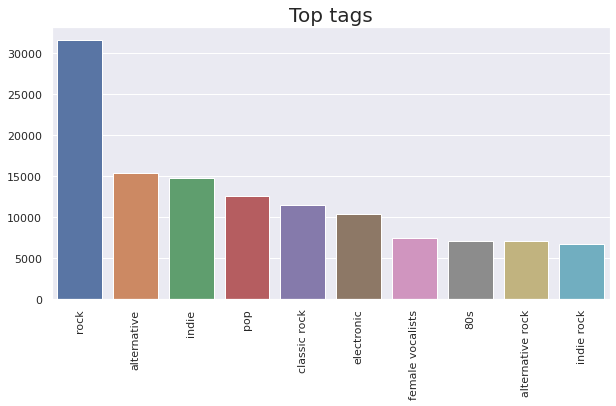

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
top_songs_plot = sns.barplot(x=list(top_tags_data_plot.keys()), y=list(top_tags_data_plot.values()))
top_songs_plot.set_xticklabels(top_songs_plot.get_xticklabels(),rotation=90)
plt.title('Top tags', fontsize=20)
#plt.show()
#!pwd
plt.savefig('top_tags.png')

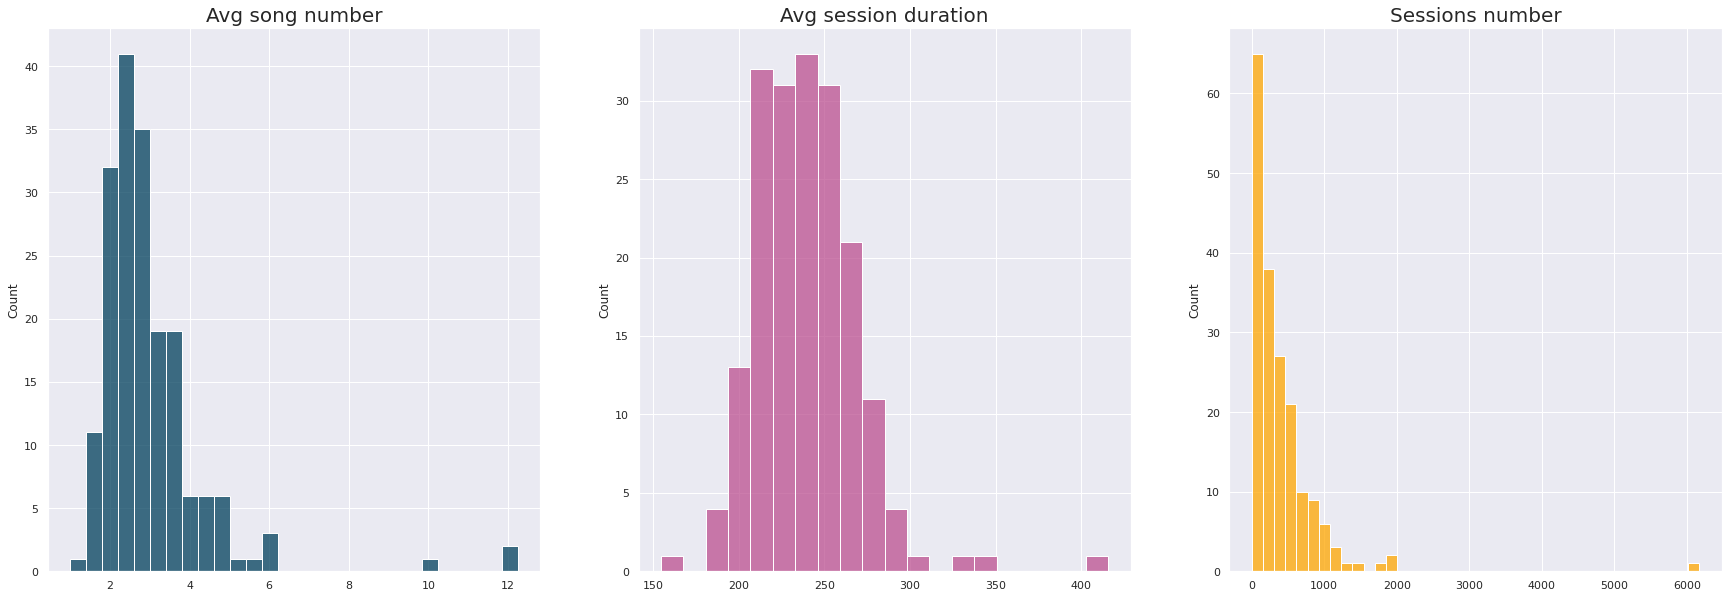

In [47]:
avg_song_number = listening_sessions_stats_rdd.map(lambda x: x[1]['avg_song_number']).collect()
avg_session_duration = listening_sessions_stats_rdd.map(lambda x: x[1]['avg_session_duration']/1000).collect()
sessions_number = listening_sessions_stats_rdd.map(lambda x: x[1]['sessions_number']).collect()
avg_song_number = [a for a in avg_song_number if a < 20]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
sns.histplot(data=avg_song_number, x=avg_song_number, ax=ax1, color='#003f5c')
ax1.set_title('Avg song number', fontsize=20)
sns.histplot(data=avg_session_duration, x=avg_session_duration, ax=ax2, color='#bc5090')
ax2.set_title('Avg session duration', fontsize=20)
sns.histplot(data=sessions_number, x=sessions_number, ax=ax3, color='#ffa600')
ax3.set_title('Sessions number', fontsize=20)
plt.savefig("sessions_stats.png")

In [48]:
max_duration_for_plot = 10 * 60 #max 10 minutes

duration_no_zero = songs_rdd.map(lambda x : x[1]['duration']/1000).filter(lambda x : x > 0).filter(lambda x : x <= max_duration_for_plot).collect()
duration_imputed = songs_rdd_imputed.map(lambda x : x[1]['duration']/1000).filter(lambda x : x <= max_duration_for_plot).collect()

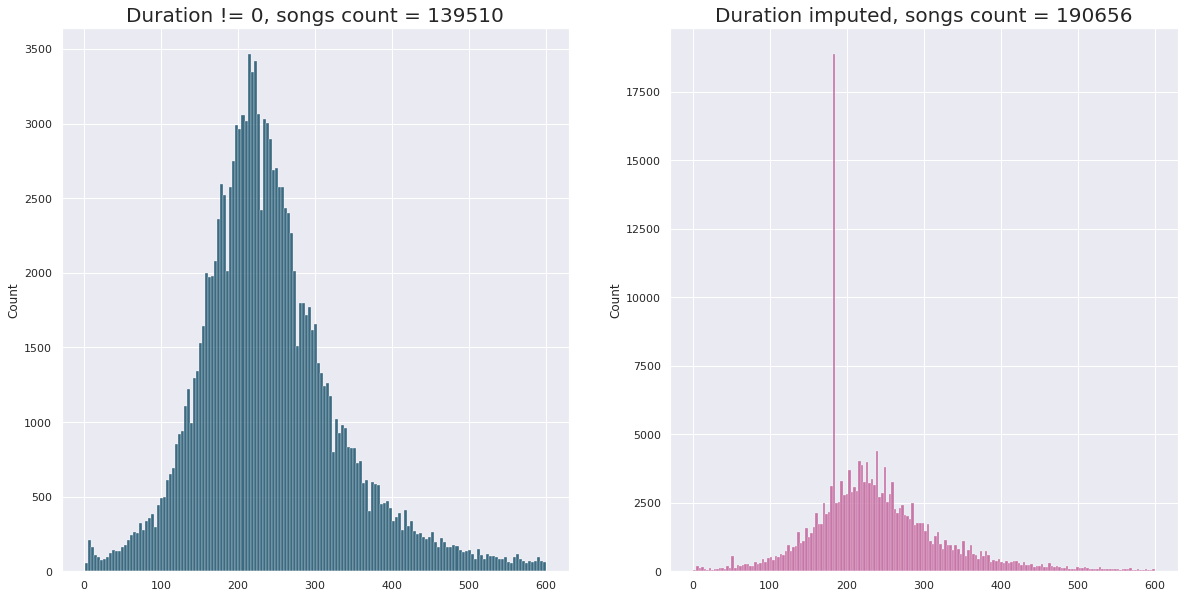

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
sns.histplot(data=duration_no_zero, x=duration_no_zero, ax=ax1, color='#003f5c')
ax1.set_title(f'Duration != 0, songs count = {len(duration_no_zero)}', fontsize=20)
sns.histplot(data=duration_imputed, x=duration_imputed, ax=ax2, color='#bc5090')
ax2.set_title(f'Duration imputed, songs count = {len(duration_imputed)}', fontsize=20)

#plt.show()
plt.savefig("songs_duration.png")

In [55]:
import numpy as np

#number of edges plot
cart = nodes_rdd.cartesian(nodes_rdd).repartition(2)
ll = []
for i in np.arange(0.95, 0, -.05):
    def filter_by_jaccard(x):
        return x[0] != x[1] and jaccard_distance(x[0], x[1]) <= i 
    cart = cart.filter(filter_by_jaccard).persist()
    ll.append((i, cart.count()))
    print(ll[-1])

(0.95, 94958)
(0.8999999999999999, 20662)
(0.8499999999999999, 12886)
(0.7999999999999998, 9798)
(0.7499999999999998, 7848)
(0.6999999999999997, 6804)
(0.6499999999999997, 6010)
(0.5999999999999996, 5012)
(0.5499999999999996, 4208)
(0.49999999999999956, 3222)
(0.4499999999999995, 2974)
(0.39999999999999947, 2258)
(0.3499999999999994, 1818)
(0.2999999999999994, 1288)
(0.24999999999999933, 842)
(0.1999999999999993, 636)
(0.14999999999999925, 352)
(0.0999999999999992, 84)
(0.049999999999999156, 2)


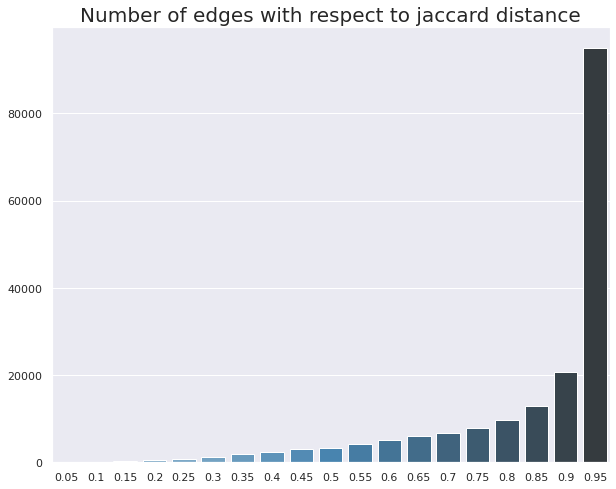

In [56]:
dd = {round(a,2) : b for a,b in ll}
plt.figure(figsize=(10, 8))
edges_plot = sns.barplot(x= list(dd.keys()), y= list(dd.values()), palette="Blues_d")

plt.title('Number of edges with respect to jaccard distance', fontsize=20)
plt.savefig("edges_jaccard.png")

In [57]:
incident_matrix.first()[1]

92

In [58]:
l = incident_matrix.map(lambda x : (x[0][0][1] == x[0][1][1], x[1])).reduceByKey(lambda a,b:a+b).collect()
d = dict(l)
same = d[True]
other = d[False]

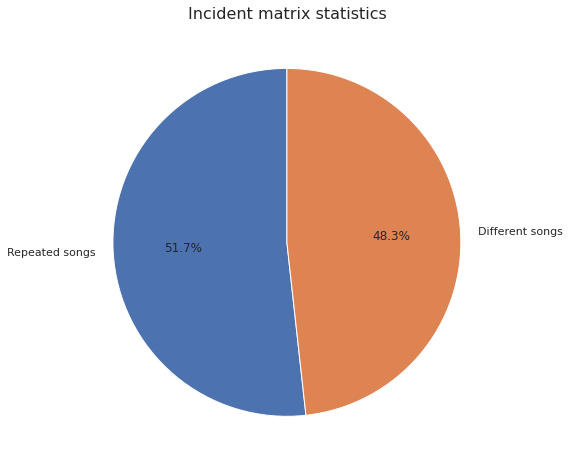

In [59]:
pie, ax = plt.subplots(figsize=[10,8])
plt.pie([same,other], labels=["Repeated songs", "Different songs"], autopct="%.1f%%", startangle=90)
plt.title("Incident matrix statistics", fontsize=16);
plt.savefig('pie.png')